In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd

In [4]:
## use train test
X_train = pd.read_csv("/Users/manankapoor/Desktop/ai_proj/cleaned_data/X_train.csv")
X_test = pd.read_csv("/Users/manankapoor/Desktop/ai_proj/cleaned_data/X_test.csv")
y_train = pd.read_csv("/Users/manankapoor/Desktop/ai_proj/cleaned_data/y_train.csv").squeeze()
y_test = pd.read_csv("/Users/manankapoor/Desktop/ai_proj/cleaned_data/y_test.csv").squeeze()

In [5]:
## handling class imbalance with scale_pos_weight we saw earlier 
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = float(neg / pos)

print(scale_pos_weight)
print(type(scale_pos_weight))


4.146520146520147
<class 'float'>


In [6]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False
)

In [7]:
model.fit(X_train, y_train)

/Users/manankapoor/Desktop/ai_proj/venv/lib/python3.14/site-packages/xgboost/training.py:200: UserWarning: [14:41:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [8]:
threshold = 0.25  # try 0.3, 0.25, 0.2

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= threshold).astype(int)

In [9]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[2279   20]
 [   5  506]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2299
           1       0.96      0.99      0.98       511

    accuracy                           0.99      2810
   macro avg       0.98      0.99      0.99      2810
weighted avg       0.99      0.99      0.99      2810


ROC AUC Score:
0.9997531471608944


In [10]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2279   20]
 [   5  506]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2299
           1       0.96      0.99      0.98       511

    accuracy                           0.99      2810
   macro avg       0.98      0.99      0.99      2810
weighted avg       0.99      0.99      0.99      2810



In [11]:
import joblib

joblib.dump(model, "server_overload_xgb.pkl")

['server_overload_xgb.pkl']

In [12]:
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']

In [13]:
import joblib
import pandas as pd


model = joblib.load("server_overload_xgb.pkl")
feature_names = joblib.load("feature_names.pkl")

def predict_overload(input_dict):
    df = pd.DataFrame([input_dict])
    df = df[feature_names]
    
    prob = model.predict_proba(df)[0][1]
    prediction = int(prob >= 0.3)  # threshold
    
    return {
        "probability": float(prob),
        "prediction": prediction
    }

In [14]:
sample = X_test.iloc[0].to_dict()
print(predict_overload(sample))

{'probability': 1.6331865481333807e-05, 'prediction': 0}


In [15]:
# --- Temperature Regression: Predict CPU1_Temp_C at T+5 ---
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare regression target
df_train = X_train.copy()
df_test = X_test.copy()

df_train['CPU1_Temp_C_Tplus5'] = df_train['CPU1_Temp_C'].shift(-5)
df_test['CPU1_Temp_C_Tplus5'] = df_test['CPU1_Temp_C'].shift(-5)

# Drop last 5 rows with NaN target
df_train_reg = df_train.dropna(subset=['CPU1_Temp_C_Tplus5'])
df_test_reg = df_test.dropna(subset=['CPU1_Temp_C_Tplus5'])

X_train_reg = df_train_reg.drop('CPU1_Temp_C_Tplus5', axis=1)
y_train_reg = df_train_reg['CPU1_Temp_C_Tplus5']
X_test_reg = df_test_reg.drop('CPU1_Temp_C_Tplus5', axis=1)
y_test_reg = df_test_reg['CPU1_Temp_C_Tplus5']

reg = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.07, random_state=42)
reg.fit(X_train_reg, y_train_reg)

# Predict and evaluate
y_pred_reg = reg.predict(X_test_reg)
rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(7,7))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.xlabel('Actual CPU1_Temp_C at T+5')
plt.ylabel('Predicted CPU1_Temp_C at T+5')
plt.title('Actual vs Predicted CPU1_Temp_C (T+5)')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.show()

TypeError: got an unexpected keyword argument 'squared'

# 📊 Project Visualizations & Model Evaluation
This section contains key diagrams and evaluation plots for your presentation: data distributions, model performance, and regression/classification results.

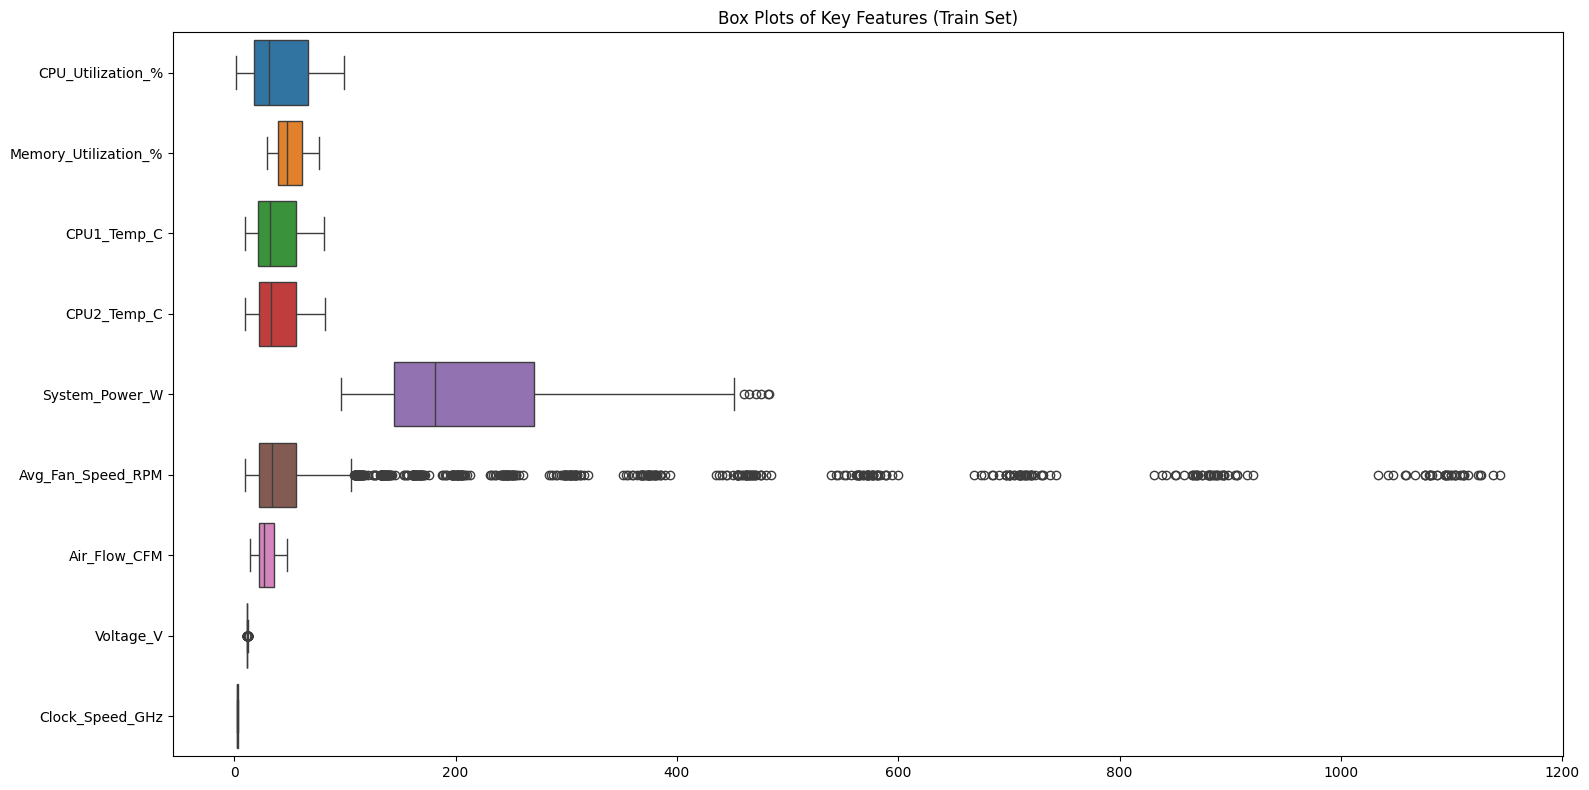

In [16]:
# --- Box Plots: Feature Distributions ---
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
selected_features = [
    'CPU_Utilization_%', 'Memory_Utilization_%', 'CPU1_Temp_C', 'CPU2_Temp_C',
    'System_Power_W', 'Avg_Fan_Speed_RPM', 'Air_Flow_CFM', 'Voltage_V', 'Clock_Speed_GHz'
]
sns.boxplot(data=X_train[selected_features], orient='h')
plt.title('Box Plots of Key Features (Train Set)')
plt.tight_layout()
plt.show()

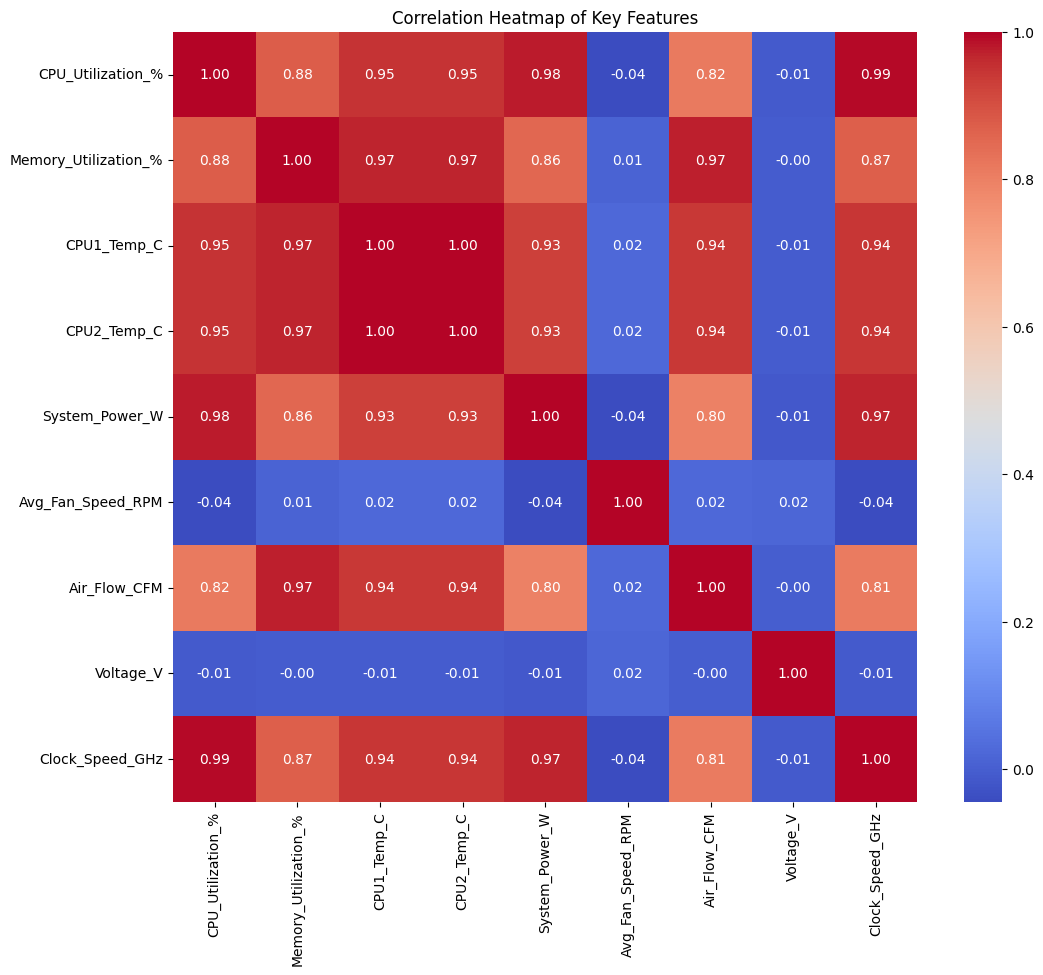

In [17]:
# --- Correlation Heatmap ---
plt.figure(figsize=(12, 10))
corr = X_train[selected_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Key Features')
plt.show()

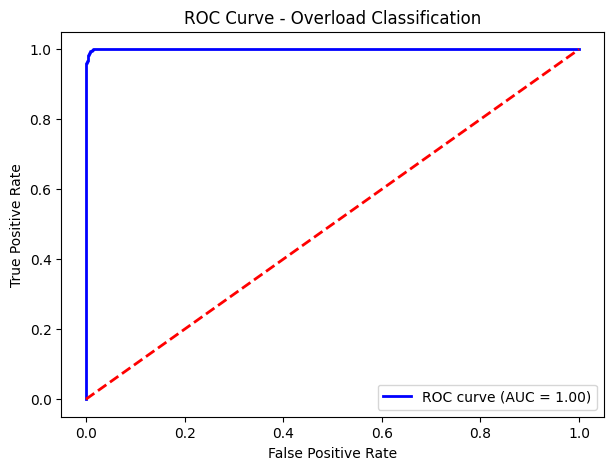

In [18]:
# --- Classification Model Evaluation: ROC Curve ---
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Overload Classification')
plt.legend(loc='lower right')
plt.show()

<Figure size 500x500 with 0 Axes>

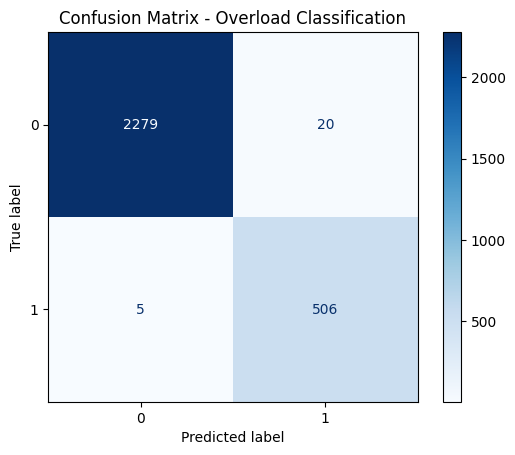

In [19]:
# --- Classification Model Evaluation: Confusion Matrix ---
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix - Overload Classification')
plt.show()

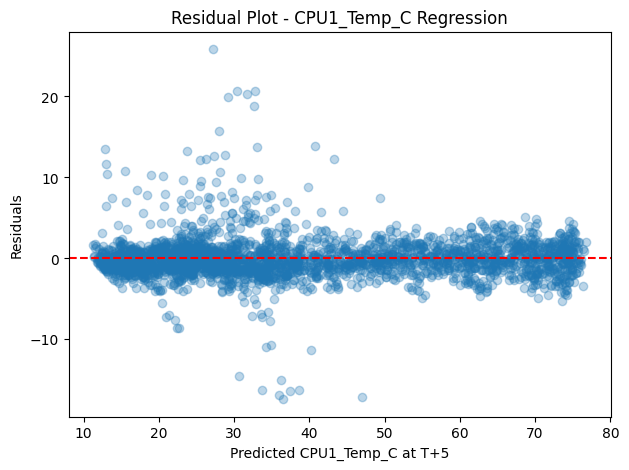

In [20]:
# --- Regression Model Evaluation: Residual Plot ---
residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(7,5))
plt.scatter(y_pred_reg, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted CPU1_Temp_C at T+5')
plt.ylabel('Residuals')
plt.title('Residual Plot - CPU1_Temp_C Regression')
plt.show()